In [1]:
import matplotlib.pyplot as plt
import numpy as np
import flow_vis
import rawpy

from skimage.color import rgb2gray
from skimage.exposure import adjust_gamma
from tqdm import tqdm

from open_utils import open_burst_of_frames, open_raw
from alignment import process_alignment
from kernel_regressor import KernelRegressor
from merge import merge
from utils import upsample_weights

# Opening images

In [2]:
directory = "./imgs6"
filename = "./imgs6/20171106_subset_bursts_33TJ_20150612_193954_263_payload_N000.dng"
up, down, left, right = 500, 800, 700, 1000
test_img, info = open_raw(filename)
orig_size_img = open_raw(filename, half_size=False)

In [3]:
burst, infos = open_burst_of_frames(directory, img_indices=range(0, 5),up=up, down=down, left=left, right=right)
raw_burst, infos = open_burst_of_frames(directory, img_indices=range(0, 5),up=up, down=down, left=left, right=right, raw_needed=True)


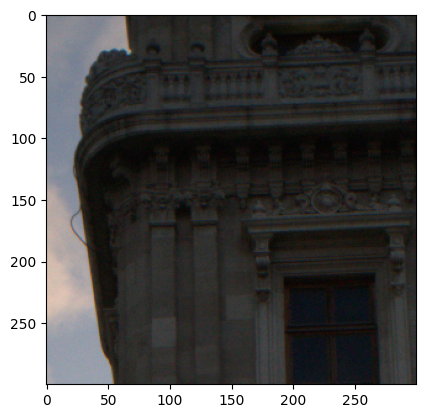

In [4]:
plt.imshow(burst[1])

# Alignment

In [5]:
flows = process_alignment(burst)

alignment for shape (300, 300, 3) taken 1.9970664978027344 seconds
alignment for shape (300, 300, 3) taken 1.8543083667755127 seconds
alignment for shape (300, 300, 3) taken 1.66011643409729 seconds
alignment for shape (300, 300, 3) taken 1.577477216720581 seconds
alignment for shape (300, 300, 3) taken 1.68326735496521 seconds


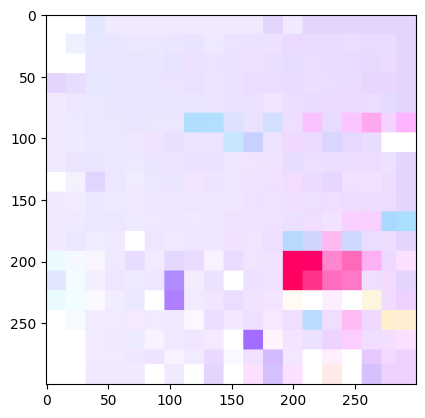

In [6]:
plt.imshow(flow_vis.flow_to_color(flows[3], convert_to_bgr=False))

# Estimating kernels

In [7]:
kr = KernelRegressor()
maps = kr.process_burst(burst, flows, silent=False)

Got structure_tensor
Got cov matrixes
Got weights for 0 frame in 31.492618322372437 seconds
Got weights for 1 frame in 31.816633701324463 seconds
Got weights for 2 frame in 30.80936574935913 seconds
Got weights for 3 frame in 31.899688482284546 seconds
Got weights for 4 frame in 31.336246490478516 seconds
Got 167.12277388572693 seconds for processing


Text(0.5, 0.98, 'Example of maps')

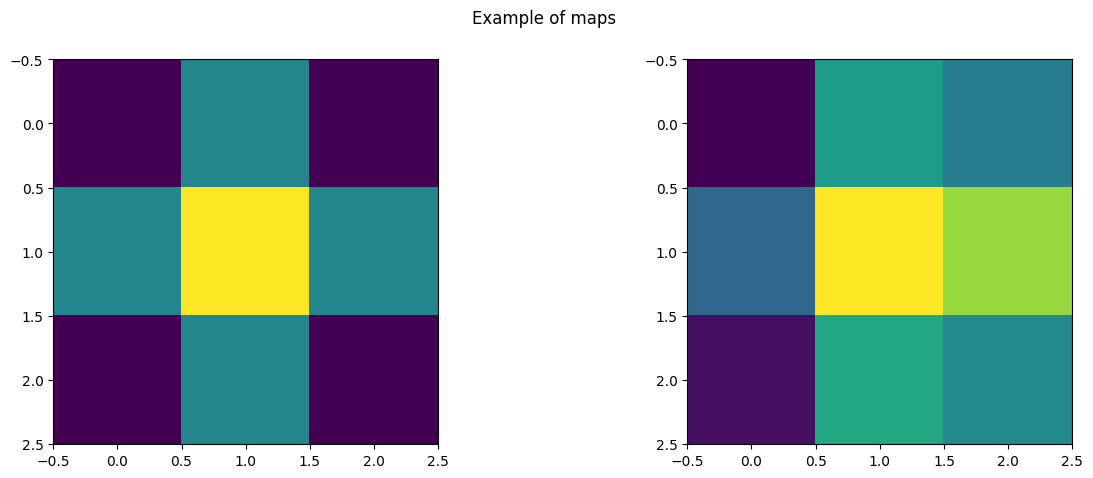

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(maps[0][100, 100, :, :])
axes[1].imshow(maps[1][100, 100, :, :])
fig.suptitle("Example of maps")

# Merging frame with multiple frames

In [9]:
upsampled_flows = [upsample_weights(flow, 0) for flow in flows]
upsampled_flows = np.nan_to_num(upsampled_flows)
upsampled_maps = [upsample_weights(map, 0) for map in maps]
upsampled_maps = np.nan_to_num(upsampled_maps)

In [10]:
merged = merge(raw_burst, np.array(upsampled_flows), np.array(upsampled_maps), verbose=True)

(600, 600, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 600/600 [04:00<00:00,  2.49it/s]


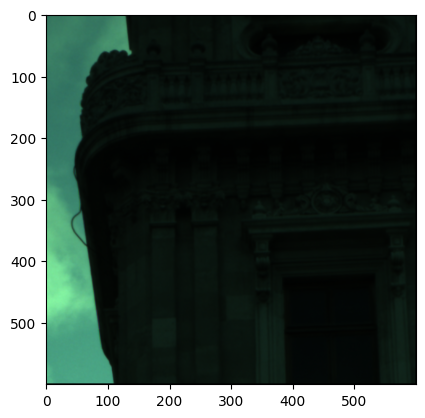

In [11]:
plt.imshow(merged / merged.max())

In [12]:
white_balance, color_matrix, white_level = infos[0]['white_balance'], infos[0]['color_matrix'], infos[0]['white_level']

In [14]:
postprocessed = postprocess(merged, white_balance, color_matrix, white_level)

# Comparison with single image demosaicing

In [15]:
orig, info = open_raw(filename, half_size=False)
orig = orig[2 * up:2 * down, 2 * left:2 * right]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Comparison on original resolution')

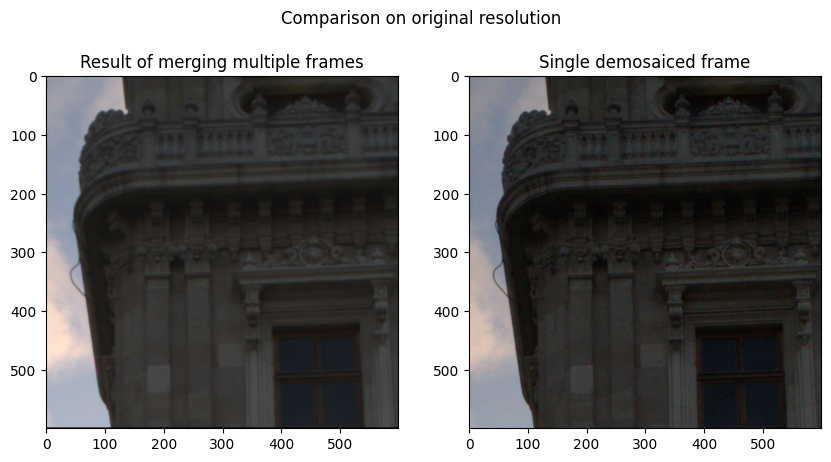

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(postprocessed)
axes[0].set_title("Result of merging multiple frames")
axes[1].imshow(orig)
axes[1].set_title("Single demosaiced frame")
fig.suptitle("Comparison on original resolution")

Text(0.5, 0.98, 'Comparison on original resolution')

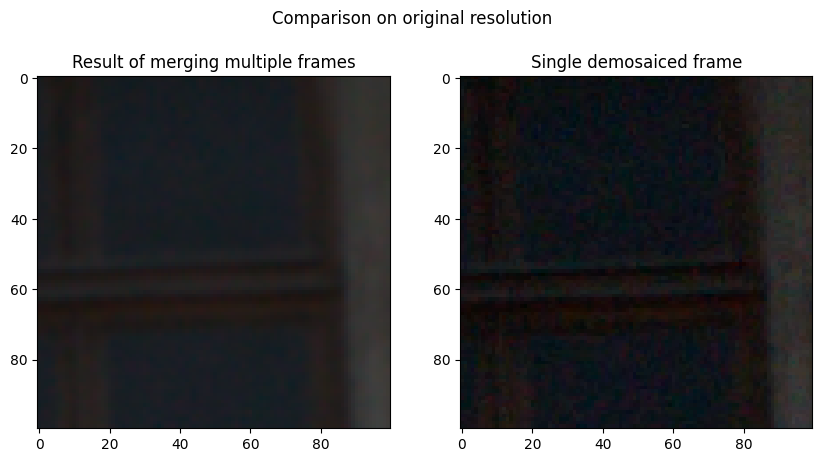

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(postprocessed[-150:-50, -150:-50])
axes[0].set_title("Result of merging multiple frames")
axes[1].imshow(orig[-150:-50, -150:-50])
axes[1].set_title("Single demosaiced frame")
fig.suptitle("Comparison on original resolution")

In [19]:
import skimage

In [20]:
skimage.io.imsave("./imgs6/merged.png", postprocessed)
skimage.io.imsave("./imgs6/orig.png", orig)
skimage.io.imsave("./imgs6/merged_piece.png", postprocessed[-150:-50, -150:-50])
skimage.io.imsave("./imgs6/orig_piece.png", orig[-150:-50, -150:-50])

Lossy conversion from float64 to uint8. Range [0.0, 1.0903255252908683]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
